## zad.1
Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny Lagrange'a . Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji.

In [58]:
using Polynomials, Plots, Interpolations, LinearAlgebra, DataFrames, Statistics

In [59]:
function lagrange_base(X, x, k, n)
    base = [(x - X[i]) / (X[k] - X[i]) for i in 1:n if i != k]
    return prod(base)
end

lagrange_base (generic function with 1 method)

In [60]:
function lagrange_value(X, Y, x)
    n = length(X)
    values = [Y[i] * lagrange_base(X, x, i, n) for i in 1:n]
    return sum(values)
end

lagrange_value (generic function with 1 method)

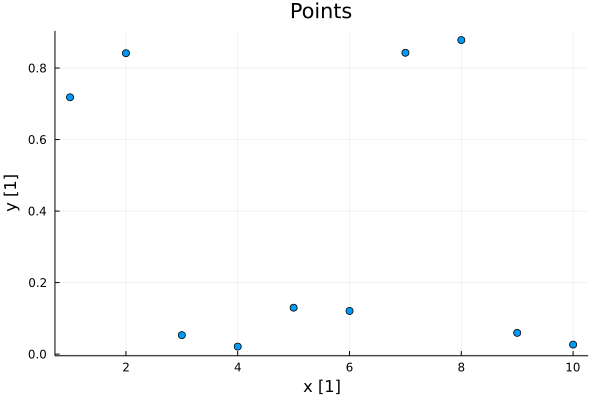

In [61]:
X = [i for i in 1:10]
Y = [rand() for x in X]
scatter(X, Y, title="Points", legend=false, xlab="x [1]", ylab="y [1]")

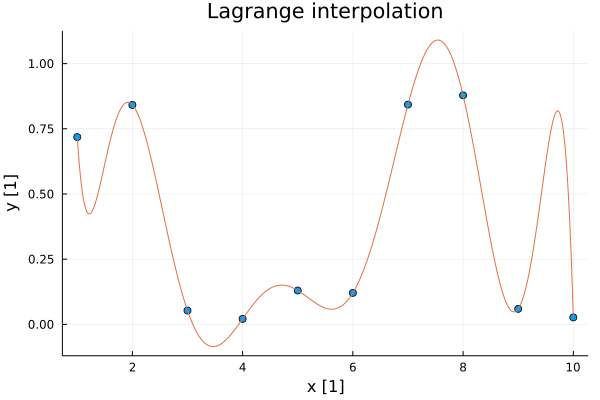

In [62]:
xs = 1:0.01:10
ys = [lagrange_value(X, Y, x) for x in xs]
plot!(xs, ys, title="Lagrange interpolation")

## zad.2
Zrobic to samo dla metody Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ :

<b>A</b> napisać funkcję NewtonInterpolation, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" newt
<br>
<b>B</b> napisać funkcję która wylicza wartość wielomianu dla obiektu newt w punkcie x za pomocą schematu Hornera dla postaci Newtona

In [63]:
function NewtonInterpolation(X, Y)
    n = length(X)
    M = zeros(Float64, (n, n))
    
    # zerowe ilorazy różnicowe
    for i in 1:n
        M[i, 1] = Y[i]
    end
    
    # pierwsze ilorazy różnicowe
    for i in 2:n
        M[i, 2] = (M[i, 1] - M[i - 1, 1]) / (X[i] - X[i - 1])
    end
    
    # kolejne ilorazy różnicowe
    for j in 3:n
        for i in j:n
            M[i, j] = (M[i, j - 1] - M[i - 1, j - 1]) / (X[i] - X[i - j + 1])
        end
    end
    
    newt = [M[i, i] for i in 1:n]
    return newt
end

NewtonInterpolation (generic function with 1 method)

In [64]:
function horners_method(X, x, newt)
    n = length(X)
    b = newt[n]
    for i in (n-1):(-1):1
        b = b * (x - X[i]) + newt[i]
    end
    return b
end

horners_method (generic function with 1 method)

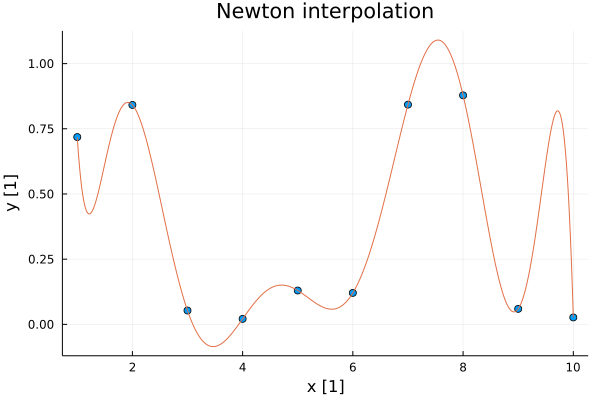

In [65]:
scatter(X, Y, title="Points")
newt = NewtonInterpolation(X, Y)
ys = [horners_method(X, i, newt) for i in xs]
plot!(xs, ys, title="Newton interpolation", legend=false, xlab="x [1]", ylab="y [1]")

## zad.3
Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego?

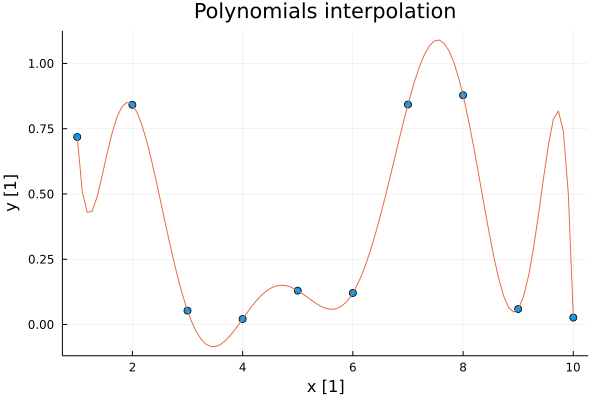

In [66]:
scatter(X, Y, title="Points")
package = fit(X, Y)
plot!(package, extrema(X)..., title="Polynomials interpolation", legend=false, xlab="x [1]", ylab="y [1]")

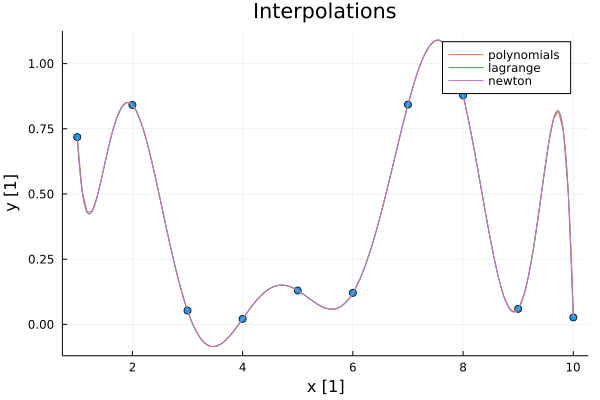

In [67]:
scatter(X, Y, title="Interpolations", xlab="x [1]", ylab="y [1]", label="")

package = fit(X, Y)
plot!(package, extrema(X)..., label="polynomials")

ys_l = [lagrange_value(X, Y, i) for i in xs]
plot!(xs, ys_l, label="lagrange")

newt = NewtonInterpolation(X, Y)
ys_n = [horners_method(X, i, newt) for i in xs]
plot!(xs, ys_n, label="newton")

Widzimy, że wykresy wielomianów pokrywają się. Jest to coś, czego oczekiwaliśmy, ponieważ zgadza się to z twierdzeniem o jednoznaczności interpolacji wielomianowej.

## zad.4
Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. Jako narzędzie do analizy danych użyć Julia DataFrames 

In [68]:
function generate_random_points(n)
    X = [i for i in 1:n]
    Y = [rand() for x in X]
    return X, Y
end

generate_random_points (generic function with 1 method)

In [69]:
function lagrange_time(X, Y, range)
    return sum([@elapsed lagrange_value(X, Y, a) for a in range])
end

function newton_time(X, Y, range)
    newt = NewtonInterpolation(X, Y)
    fst = @elapsed NewtonInterpolation(X, Y)
    snd = sum([@elapsed horners_method(X, b, newt) for b in range])
    return fst + snd
end

function polynomials_time(X, Y, range)
    package = fit(X, Y)
    fst = @elapsed fit(X, Y)
    snd = sum([@elapsed package(c) for c in range])
    return fst + snd
end

polynomials_time (generic function with 1 method)

In [70]:
df1 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [71]:
jump = 10
treadmill = jump:jump:10*jump

10:10:100

In [72]:
for i in treadmill
    range = 1:0.01:i
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df1, [i "lagrange" lagrange_time(X, Y, range)])
        push!(df1, [i "newton" newton_time(X, Y, range)])
        push!(df1, [i "polynomials" polynomials_time(X, Y, range)])
    end
end
df1

,points,interpolation,time
,Int64,String,Float64
1,10,lagrange,0.0026615
2,10,newton,3.26e-5
3,10,polynomials,3.33e-5
4,10,lagrange,0.002683
5,10,newton,3.22e-5
6,10,polynomials,3.23e-5
7,10,lagrange,0.0026384
8,10,newton,3.23e-5
9,10,polynomials,3.3e-5


In [73]:
df1_grouped = groupby(df1, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,10,lagrange,0.0026615
2,10,lagrange,0.002683
3,10,lagrange,0.0026384
4,10,lagrange,0.0163667
5,10,lagrange,0.0020195
6,10,lagrange,0.0018255
7,10,lagrange,0.001833
8,10,lagrange,0.0026715
9,10,lagrange,0.0028558


In [74]:
df1_combined = combine(df1_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,10,lagrange,0.00384926,0.00441761
2,10,newton,3.267e-5,6.39531e-7
3,10,polynomials,3.263e-5,4.29599e-7
4,20,lagrange,0.0139791,0.00503509
5,20,newton,7.785e-5,2.97555e-6
6,20,polynomials,7.464e-5,1.33016e-6
7,30,lagrange,0.0372338,0.0034584
8,30,newton,0.00014279,4.45338e-5
9,30,polynomials,0.00013696,4.73607e-5


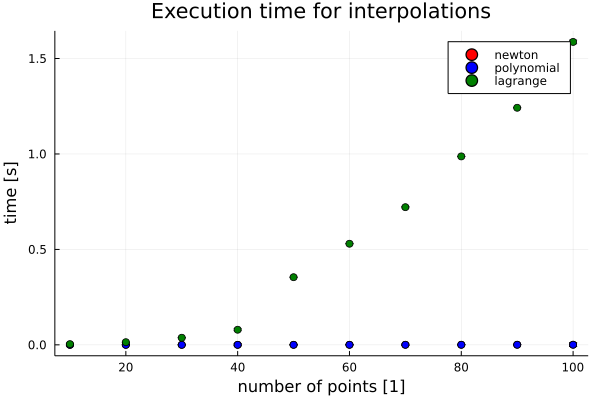

In [75]:
scatter([df1_combined[df1_combined[:,2] .== "newton", :].points df1_combined[df1_combined[:,2] .== "polynomials", :].points df1_combined[df1_combined[:,2] .== "lagrange", :].points],
    [df1_combined[df1_combined[:,2] .== "newton", :].time_mean df1_combined[df1_combined[:,2] .== "polynomials", :].time_mean df1_combined[df1_combined[:,2] .== "lagrange", :].time_mean],
    colour = [:red :blue :green],
    yerr = df1_combined.time_std,
    label = ["newton" "polynomial" "lagrange"],
    title = "Execution time for interpolations",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

In [76]:
function newton_preparation_time(X, Y)
    return @elapsed NewtonInterpolation(X, Y)
end

function polynomials_preparation_time(X, Y)
    return @elapsed fit(X, Y)
end

polynomials_preparation_time (generic function with 1 method)

In [77]:
df2 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [78]:
jump = 200
treadmill = jump:jump:10*jump

200:200:2000

In [79]:
for i in treadmill
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df2, [i "newton" newton_preparation_time(X, Y)])
        push!(df2, [i "polynomials" polynomials_preparation_time(X, Y)])
    end
end
df2

,points,interpolation,time
,Int64,String,Float64
1,200,newton,6.39e-5
2,200,polynomials,5.68e-5
3,200,newton,6.02e-5
4,200,polynomials,4.02e-5
5,200,newton,0.0001259
6,200,polynomials,4.0e-5
7,200,newton,8.32e-5
8,200,polynomials,3.95e-5
9,200,newton,0.0001114


In [80]:
df2_grouped = groupby(df2, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,200,newton,6.39e-5
2,200,newton,6.02e-5
3,200,newton,0.0001259
4,200,newton,8.32e-5
5,200,newton,0.0001114
6,200,newton,0.0001168
7,200,newton,0.0001156
8,200,newton,6.48e-5
9,200,newton,0.0001118


In [81]:
df2_combined = combine(df2_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,200,newton,9.678e-5,2.57598e-5
2,200,polynomials,4.15e-5,5.38269e-6
3,400,newton,0.00117752,0.00237298
4,400,polynomials,0.00017112,3.91453e-5
5,600,newton,0.00082899,0.000204389
6,600,polynomials,0.0004077,0.000117003
7,800,newton,0.00196755,0.00152505
8,800,polynomials,0.00068434,0.000181612
9,1000,newton,0.00292384,0.00115538


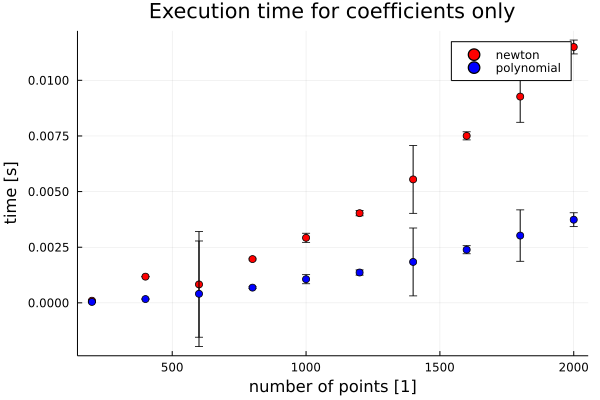

In [82]:
scatter([df2_combined[df2_combined[:,2] .== "newton", :].points df2_combined[df2_combined[:,2] .== "polynomials", :].points],
    [df2_combined[df2_combined[:,2] .== "newton", :].time_mean df2_combined[df2_combined[:,2] .== "polynomials", :].time_mean],
    colour = [:red :blue],
    yerr = df2_combined.time_std,
    label = ["newton" "polynomial"],
    title = "Execution time for coefficients only",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

In [83]:
function newton_values_time(X, Y, range)
    newt = NewtonInterpolation(X, Y)
    return sum([@elapsed horners_method(X, b, newt) for b in range])
end

function polynomials_values_time(X, Y, range)
    package = fit(X, Y)
    return sum([@elapsed package(c) for c in range])
end

polynomials_values_time (generic function with 1 method)

In [84]:
df3 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [85]:
jump = 100
treadmill = jump:jump:10*jump

100:100:1000

In [86]:
for i in treadmill
    range = 1:0.01:i
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df3, [i "newton" newton_values_time(X, Y, range)])
        push!(df3, [i "polynomials" polynomials_values_time(X, Y, range)])
    end
end
df3

,points,interpolation,time
,Int64,String,Float64
1,100,newton,0.0008371
2,100,polynomials,0.0006489
3,100,newton,0.0008682
4,100,polynomials,0.0006426
5,100,newton,0.000813
6,100,polynomials,0.0006468
7,100,newton,0.0008444
8,100,polynomials,0.000645
9,100,newton,0.0012979


In [87]:
df3_grouped = groupby(df3, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,100,newton,0.0008371
2,100,newton,0.0008682
3,100,newton,0.000813
4,100,newton,0.0008444
5,100,newton,0.0012979
6,100,newton,0.0008417
7,100,newton,0.0008389
8,100,newton,0.0008377
9,100,newton,0.0008435


In [88]:
df3_combined = combine(df3_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,100,newton,0.00088469,0.000145875
2,100,polynomials,0.00064676,3.9164e-6
3,200,newton,0.00267966,9.21969e-6
4,200,polynomials,0.00179611,6.21923e-6
5,300,newton,0.00605581,0.00166117
6,300,polynomials,0.00273889,2.63371e-5
7,400,newton,0.00938385,1.53566e-5
8,400,polynomials,0.00371164,0.000219564
9,500,newton,0.0142779,0.000138016


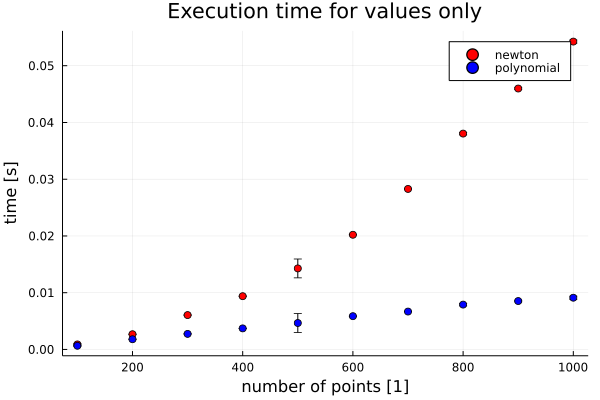

In [89]:
scatter([df3_combined[df3_combined[:,2] .== "newton", :].points df3_combined[df3_combined[:,2] .== "polynomials", :].points],
    [df3_combined[df3_combined[:,2] .== "newton", :].time_mean df3_combined[df3_combined[:,2] .== "polynomials", :].time_mean],
    colour = [:red :blue],
    yerr = df3_combined.time_std,
    label = ["newton" "polynomial"],
    title = "Execution time for values only",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

## zad.5
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.

In [90]:
function neville(X, Y, x)
    n = length(X)
    P = zeros(Float64, n)
    
    for i in 1:n
        P[i] = Y[i]
        for j in i-1:-1:1
            P[j] = P[j+1] + (P[j+1] - P[j]) * (x - X[i]) / (X[i] - X[j])
        end
    end
    
    return P[1]
end

neville (generic function with 1 method)

In [91]:
X = [i for i in 1:10]
Y = [rand() for x in X]
xs = [1.23, 2.54, 4.19, 6.43, 8.89]
newt = NewtonInterpolation(X, Y)

10-element Vector{Float64}:
  0.1795893431623482
  0.7492845517757787
 -0.4088559356823811
  0.1357757060883125
 -0.05315754841519344
  0.026816296483547396
 -0.01104149005782875
  0.0033539842766081335
 -0.0007885633409641709
  0.00015140114357735176

In [92]:
for x in xs
    newton = horners_method(X, x, newt)
    nevil = neville(X, Y, x)
    println("Point: ", x, " Newton: ", newton, " Neville: ", nevil, " Difference: ", abs(newton - nevil))
end

Point: 1.23 Newton: 2.2739506020206326 Neville: 2.273950602020637 Difference: 4.440892098500626e-15
Point: 2.54 Newton: 0.5469072981687736 Neville: 0.5469072981687736 Difference: 0.0
Point: 4.19 Newton: 0.6389875510003296 Neville: 0.6389875510003294 Difference: 1.1102230246251565e-16
Point: 6.43 Newton: 0.9195920436013223 Neville: 0.9195920436013225 Difference: 2.220446049250313e-16
Point: 8.89 Newton: 0.8243334628346521 Neville: 0.8243334628346526 Difference: 4.440892098500626e-16


## zad.6
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b>

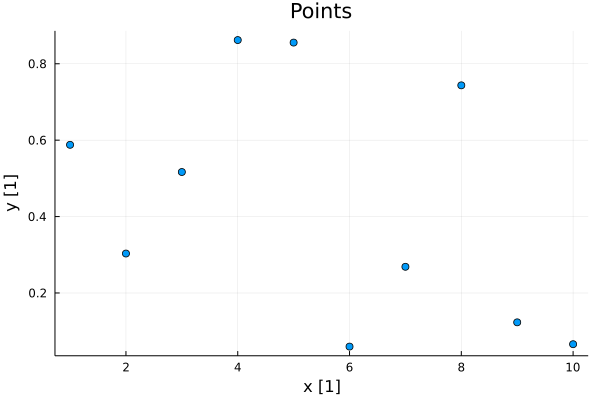

In [93]:
X = 1:10
Y = [rand() for x in X]
scatter(X, Y, label="", title="Points", xlab="x [1]", ylab="y [1]")

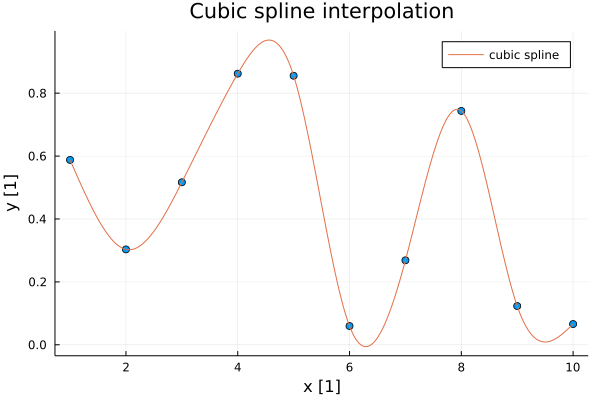

In [94]:
xs = [i for i in 1:0.01:10]
cubic_spline = CubicSplineInterpolation(X, Y)
ys_spline = [cubic_spline(x) for x in xs]
plot!(xs, ys_spline, label="cubic spline", title="Cubic spline interpolation")

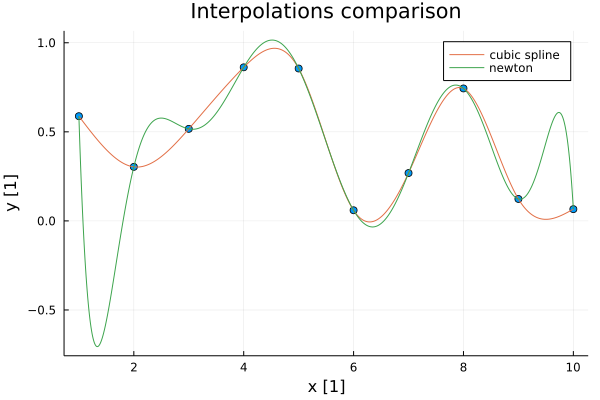

In [95]:
newt = NewtonInterpolation(X, Y)

ys_newton = [horners_method(X, x, newt) for x in xs]
plot!(xs, ys_newton, label="newton", title="Interpolations comparison")

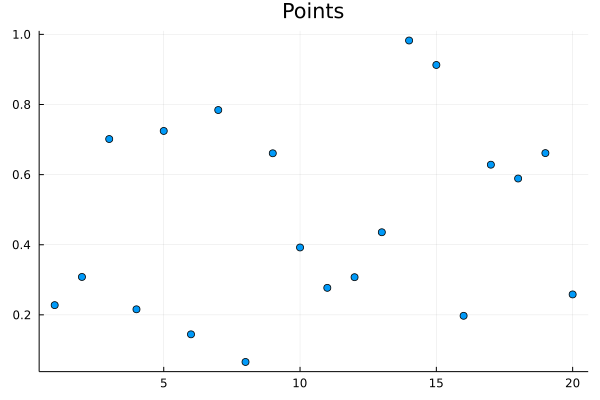

In [100]:
X = 1:20
Y = [rand() for x in X]
scatter(X, Y, label="", title="Points")

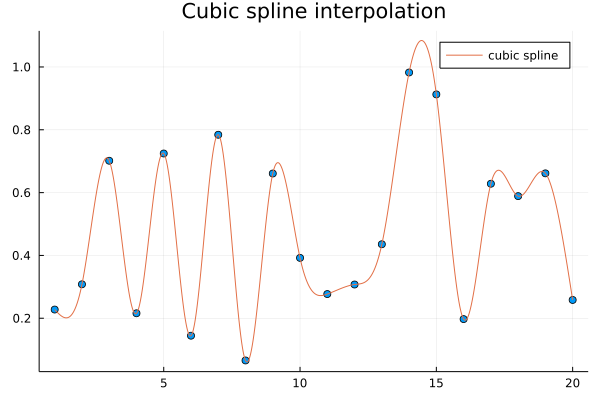

In [101]:
xs = [i for i in 1:0.01:20]
cubic_spline = CubicSplineInterpolation(X, Y)
ys_spline = [cubic_spline(x) for x in xs]
plot!(xs, ys_spline, label="cubic spline", title="Cubic spline interpolation")

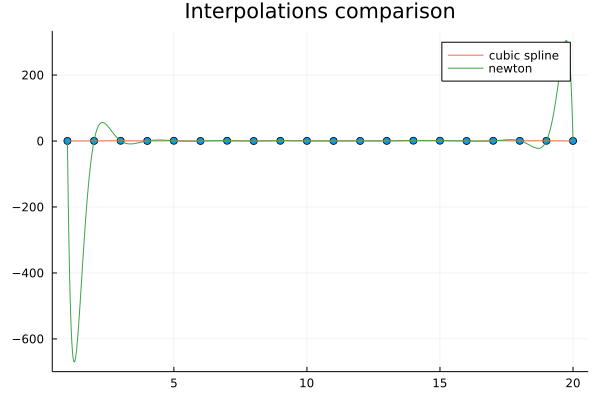

In [102]:
newt = NewtonInterpolation(X, Y)

ys_newton = [horners_method(X, x, newt) for x in xs]
plot!(xs, ys_newton, label="newton", title="Interpolations comparison")

Im więcej mamy węzłów interpolacji, tym gorszym pomysłem jest korzystanie z metody Newtona. 
Na krańcach przedziału obserwujemy efekt Rungego, który dla 20 węzłów absurdalnie zaburza otrzymane wyniki

Konstrukcja wielomianu z wykorzystaniem funkcji sklejanych daje sensowne rezultaty i jest lepszym wyborem od próby konstrukcji wielomianu bardzo wysokiego stopnia